# A Randomized Algorithm for Finding Frequent Elements in Streams using O(log log N) Space
## by Masatora Ogata, Yukiko Yamauchi, Shuji Kijima, and Masafumi Yamashita
author: Jacob Schreiber


Trying to find frequent elements in a stream of data is a common problem amongst data wranglers, with examples include trying to find common purchases at a supermarket in real time, or identifying the most common IP addresses visiting website. A naive solution to this problem is simply to have a key-value store where the count of each item is stored and common elements can be extracted easily. However, this requires a massive amount of memory, with each key requiring a count. This problem is exacerbated in the big data setting, even the full set of keys may not be able to be stored in memory. 

## Prior Work

There has been much prior work done on trying to find frequent items in a stream of data. A common approach is the Majority Vote Algorithm which was discovered by Boyer and Moore in the 1980's. Since then, there have been many variations and improvements upon this initial idea, such as work by <i>Karp, Shenker, and Papadimitriou</i> which allow for false positives, but not false negatives.

The Majority Vote algorithm is an exact solution to this problem if the most common element occurs more than half the time in the stream. All the algorithm has to do is store a single key-count pair which takes $O(\log n + \log m)$ memory, where $n$ is the size of the stream and $m$ is the number of unique elements in the stream. These values are initially null. For every item seen, if the item is equal to the key, the count is increased by 1. If the item is not equal to the key, the count is decreased by 1. If the count is 0, then replace the key with the seen item with a count of 1. 

Theoretically this can be proven by considering a key $k$ which occurs strictly more than half of the time, or  $\sum\limits_{i=0}^{n} 1_{x_{i} \neq k} < \sum\limits_{i=0}^{n} 1_{x_{i} = k}$ If this happens, it means that by the end of the stream, the key must occur. There is no ordering of elements such that this algorithm does not return the most likely key with a count equal to the imbalance between the two.

Lets see a simple program which does that.

In [1]:
class FrequentFinder(object):
    """Finds frequent items in a stream of data."""
    
    def __init__(self):
        self.key = -1
        self.count = 0
    
    def summarize(self, x):
        """See an integer and update the internal state appropriately."""
        
        if x == self.key:
            self.count += 1
        elif x != self.key and self.count > 0:
            self.count -= 1
        else:
            self.key = x
            self.count = 1        

Lets test this out on a simple case, a list of binary values where there are $n$ zeros and $n+1$ ones, ordered such that

\begin{equation}
X_{i} = 
    \begin{cases}
       0, & \text{if i mod } 2 = 1 \\
       1, & \text{otherwise}
    \end{cases}
\end{equation}

In [2]:
import numpy
data = numpy.zeros(10001)
data[::2] = 1

ff = FrequentFinder()
for x in data:
    ff.summarize(x)

print "Most Common Key: {}".format(ff.key)
print "Count: {}".format(ff.count)

Most Common Key: 1.0
Count: 1


Looks like it was able to find that out properly. The count is, in fact, equal to the imbalance between the most frequent item and the the remainder of the items. If we made it so that there were 100 ones and 75 of all other values, the count would be equal to 25.

Before moving on, lets experimentally show that this works with a large number of possible values and a large stream of data. Say, lets look at ten millions points randomly selected between 0 and 100,000,000,000,000 (100 trillion), where slightly over half of them are 7. If we wanted to store integer counts for all possibilities so that we could later take the maximum we would need 3.2 petabytes of space. There are more efficient, sparser ways of doing this, but even these sparse ways (such as only storing numbers which we have seen) grow linearly with the size of the stream.

In [3]:
ff = FrequentFinder()
ff.summarize(7)
for i in xrange(10000000):
    if i % 2 == 0:
        ff.summarize(7)
    else:
        ff.summarize(numpy.random.randint(100000000000000))

print "Most Common Element: {}".format(ff.key)
print "Element Count: {}".format(ff.count)

Most Common Element: 7
Element Count: 1


It looks like this algorithm is able to work well <i>storing only two numbers</i> even with over 100 trillion possible numbers which could be the most frequent element. This algorithm can be trivially extended to count the $n$ most frequent item when each item occurs strictly more than $\frac{1}{n+1}$ of the time, with the amount of memory at $O(n)$ for storing the $n$ most frequent elements. 

However, requiring that the common items occur more than $\frac{1}{n+1}$ of the time can be a very strict requirement. Consider the case where we want the most common element, but it only occurs one tenth of the time among a billion possibilities. This is still a massive enrichment for that item, but this algorithm would be unable to pick up on that. 

However, if the need for an exact solution were relaxed, approximate algorithms can provide improvements. One well known one was proposed by Toivonen and involves uniform random sampling of the data, requiring only $O(\frac{1}{\epsilon^{2}}\log(\frac{N}{\epsilon})$ memory and the ability to return all common items with a probability $1-\delta$. An improvement on this, called 'sticky sampling', uses an adaptive sampling rate based on the number of items which it has seen, for better coverage of the data.  

This paper relaxes that requirement to the problem of identifying frequent elements such that each item occurs at least $\theta$ percentage of the time (for $\theta \in (0, 1)$). Previous algorithms were able to do this in $O(log n)$ space, but a major contribution of this paper is their algorithm can do it requiring only $O(log log n)$ memory, a drastic reduction.

An important point to consider is that this algorithm is not an exact algorithm, but a randomized algorithm. This means that it is unlikely to return the best answer, but with a high probability it will return a good answer. Specifically The algorithm is an approximate algorithm, meaning that it may not return the exact best answer, but with high probability it will return a good answer. Specifically in this case, there is a probability $1 - \delta$ that all frequent items ($\text{count(key)} \geq \theta N$) are returned and no infrequent items ($\text{count(key)} < (1 - \gamma)\theta N$) are. This algorithm requires user input for $\theta$ (the frequency an item must be to be 'common'), $\delta$ (the acceptable error), and $\gamma$ (the margin with which to not return negatives).

## The Algorithm

The pseudocode for the algorithm is provided by the authors in the paper, slightly rewritten for clarity by me:

Let K denote a data structure which stores $2^{b}$ key-count pairs, where b is the number of bytes we want to allocate to storing counts.

(0) Initialize K: Set exponent parameter h = 0 <br>
(1) Read $x_{i}$ as $s$, if no more input then goto 5 <br> 
(2) With probability $2^{-h}$, K[s] += 1 if s is in K, otherwise K[s] = 1 <br>
(3) If $\sum\limits_{s \in K} K[s] = 2^{b}$, then flush k: <br>
$\quad$ (3a) h += 1 <br>
$\quad$ (3b) For each s in K: <br>
$\quad\quad$ choose k with probability ${K[s]}\choose{k}$ / 2^{K[s]} <br>
$\quad\quad$ K[s] = k <br>
$\quad$ (3c) Delete symbol s $\in$ K if K[s] = 0 <br>
(4) Goto 1 <br>
(5) Output every s such that $K[s] \geq (1-\frac{\gamma}{2})\theta \sum\limits_{s' \in K} K[s']$

The intuition behind this algorithm is that it stores $b$ items before being reset, and upon resetting, uses the binomial distribution to randomly discard items weighted by their counts. Stored items with a higher count have a smaller chance of being discarded through this distribution, whereas items with lower counts have a higher probability of being discarded. We can see a visualization of this below:

Populating the interactive namespace from numpy and matplotlib


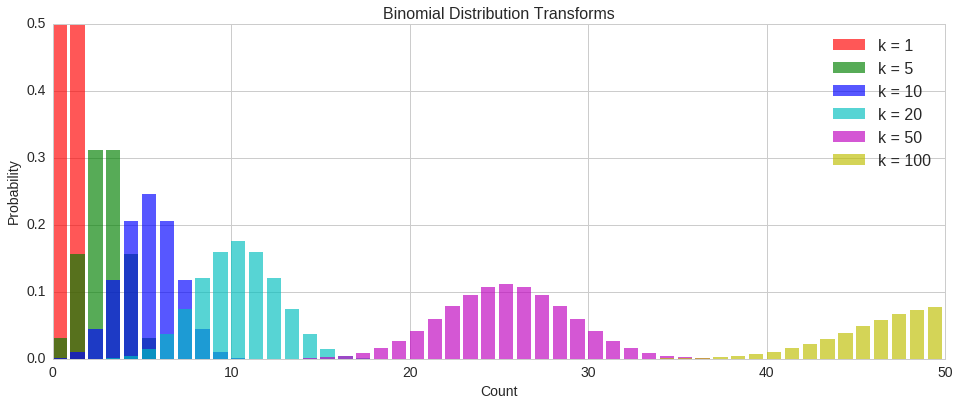

In [4]:
%pylab inline
from scipy.misc import comb 
import seaborn
seaborn.set_style('whitegrid')

def binomialSample(count, d):
    """Return a sample with probability according to step 3b"""
    p = numpy.zeros(d)
    for i in range(d):
        p[i] = comb(count, i) / (2**count)
    return p

plt.figure(figsize=(16, 6))
for i, color in zip( [1, 5, 10, 20, 50, 100], 'rgbcmyk'):
    plt.bar( range(50), binomialSample(i, 50), facecolor=color, linewidth=0, 
             alpha=0.66, label="k = {}".format(i) )

plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.xlabel("Count", fontsize=14)
plt.title("Binomial Distribution Transforms", fontsize=16)
plt.show()

From this is it intuitive to see that larger initial values (k) have a small chance of having their counts set equal to 0 and tossed out, whereas smaller numbers have a much higher chance. For example there is a 50% chance that an original count of 1 will be tossed out, but an infentesimal chance that an initial count of 50 will. Another thing to note is that it is impossible to get a higher value than the original count, and the expected value of this transformation is to half the count currently in each bin. This means that every 'flush' step (step 3) is expected to clear out half of the data structure.

Lets now implement the algorithm. We can do it in a similar manner to the majority vote algorithm, where we have a class which stores some running statistics as we see the stream and will return the most frequent elements at different times. We also need to modify the binomialSample method to return a random sample instead of an array of probabilities. 

In [5]:
def log_comb(n, k):
    m = numpy.log2(numpy.arange(n-k+1, n+1)).sum()
    q = numpy.log2(numpy.arange(1, k+1)).sum()
    return m-q

def binomialSample(count):
    """Return a sample with probability according to step 3b"""
    
    p = 0.0
    r = numpy.random.random()
    for i in range(count+1):
        p += 2**(log_comb(count, i) - count)
        if r <= p:
            return i
    
class FrequentFinder(object):
    """Finding frequent stuff."""
    
    def __init__(self, b):
        self.b = 2**b

        # Step 0
        self.h = 0
        self.h2 = 1
        self.K = {}
        self.n = 0
    
    def summarize(self, x):
        # Step 1 is calling this method
        # Step 2: With probability 2**-h do something
        if numpy.random.random() <= self.h2:
            self.n += 1
            
            # Step 2: Increment the counter
            if x in self.K:
                self.K[x] += 1
            else:
                self.K[x] = 1
            
            # Step 3: If equal to 2**b then flush
            if self.n == self.b:
                # Step 3a: Increment h
                self.h += 1
                self.h2 = 2**-self.h
                self.n = 0
                
                # Step 3b: Get new counts
                for key, value in self.K.items():
                    self.K[key] = binomialSample(value)
                    self.n += self.K[key]
                
                # Step 3c: Delete counts equal to 0
                for key, value in self.K.items():
                    if value == 0:
                        del self.K[key]
                    
    def from_summaries(self, theta, gamma):
        # Step 5 is calling this method
        thresh = (1 - gamma/2.) * theta * self.n
        return [s for s, count in self.K.items() if count >= thresh]

This algorithm is implemented as an object, where step 0 is the `__init__` method, steps 1 through 3c are implemented in the summarize method for each time an item is seen in the stream, and step 5 is implemented as the `from_summaries` method. 

It's important to note that Python does not implement the most efficient numeric datatypes, and so while an integers are frequently implemented using 8 bits, and theoretically could be done in even 3 or 5 bits, Python is using 64 bits to represent each integer. For the purposes of this tutorial, we are ignoring that detail and only showing how the algorithm works with the remark that the most efficient implementation of this algorithm would use differing sized ints.

Lets look at two quick examples:
(1) the same example as before, where there are 100 trillion possibilities but 7 occurs more than half the time

In [6]:
ff = FrequentFinder(2)
ff.summarize(7)
for i in xrange(10000000):
    if i % 2 == 0:
        ff.summarize(7)
    else:
        ff.summarize(numpy.random.randint(100000000000000))

print ff.from_summaries(0.49, 0.01)

[7]


(2) the same example as before, except we have 5 different values each occuring at least 1/20th of the time. This is an example which couldn't be done using the majority vote algorithm, despite there being a significant enrichment of these items compared to the 100 trillion possibilities. Lets set these enriched values to be 7, 13, 29, 86, and 1072. We should expect to see these returned at the end of the stream.

In [7]:
ff = FrequentFinder(8)

for i in xrange(10000000):
    if i % 20 == 0:
        ff.summarize(7)
    elif i % 20 == 1:
        ff.summarize(13)
    elif i % 20 == 2:
        ff.summarize(29)
    elif i % 20 == 3:
        ff.summarize(86)
    elif i % 20 == 4:
        ff.summarize(1072)
    else:
        ff.summarize(numpy.random.randint(100000000000000))

print ff.from_summaries(0.01, 0.01)

[7, 13, 29, 1072, 86]


And they are. Lets first write a function which will allow us to visualize the top values in the dictionary, with the keys on the x-axis, and the count for these keys on the y-axis, ordered by the count. We're also expecting there to be a huge number of keys with a count of 1, so lets only look at the top 25 items to ensure we get all the useful data.

In [8]:
def dict_to_plot(d, thresh, n):
    """Plot the frequency of the most frequent n elements in the dictionary."""
    
    plt.figure(figsize=(12, 8))
    plt.title("Frequency of Items", fontsize=16)
    plt.xlabel("Key", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    
    data = numpy.array(sorted(d.items(), key=lambda x: x[1], reverse=True)[:n])
    t = data[:,1] < thresh
    s = data[:,1] >= thresh
    idx = numpy.arange(n)
    
    plt.bar(idx[t], data[t,1], facecolor='c', linewidth=0, alpha=0.66)
    plt.bar(idx[s], data[s,1], facecolor='r', linewidth=0, alpha=0.66)
    
    plt.yticks(fontsize=14)
    plt.xticks(idx+0.5, data[:,0], rotation=90, fontsize=12)
    plt.plot([0, n], [thresh, thresh], c='m', alpha=0.66, linewidth=2, label="Threshold" )
    plt.legend(fontsize=16)
    plt.show()

Now lets use this to visualize the results from the algorithm, with red bars indicating elements which would be returned by the algorithm, and cyan bars indicating elements which would not be returned.

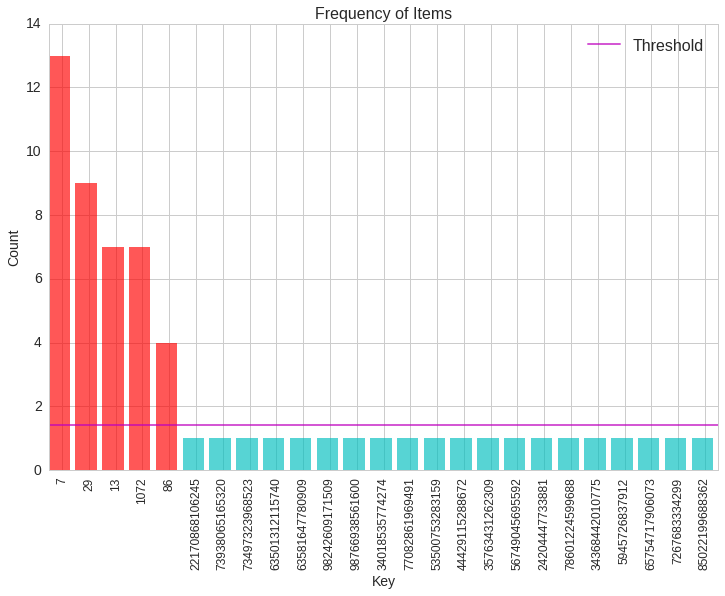

In [9]:
dict_to_plot(ff.K, (1-0.01/2)*0.01*ff.n, 25)

Looks like the uncommon values are only being stored with a count of 1. This makes a lot of sense, as we would only expect to see most of these elements once. After each flush, we then have a 50% chance of removing them, and so would still see many of them. However, the frequent elements do occur with significantly higher, though not necessarily representative, counts. An interesting thing to note is that if our cutoff was the generating probability of $\frac{1}{20}$ we would miss the 1072, helping to illustrate the randomness intrinsic to the algorithm:

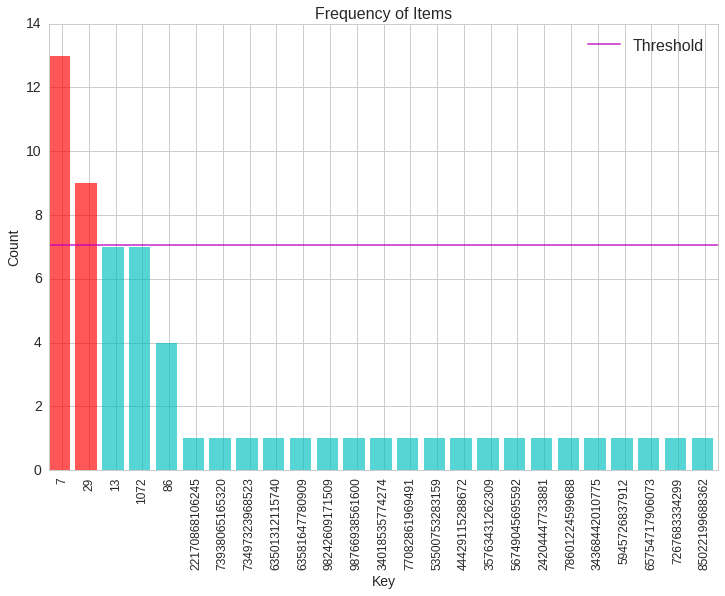

In [10]:
dict_to_plot(ff.K, (1-0.01/2)*0.05*ff.n, 25)

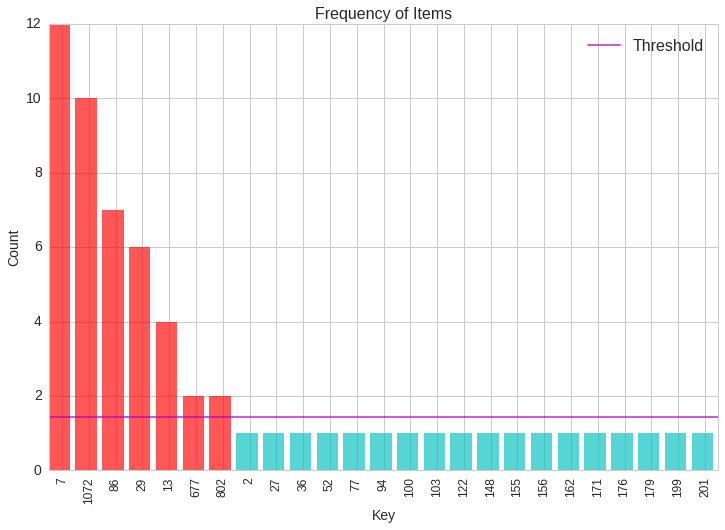

In [11]:
ff = FrequentFinder(8)

for i in xrange(10000000):
    if i % 20 == 0:
        ff.summarize(7)
    elif i % 20 == 1:
        ff.summarize(13)
    elif i % 20 == 2:
        ff.summarize(29)
    elif i % 20 == 3:
        ff.summarize(86)
    elif i % 20 == 4:
        ff.summarize(1072)
    else:
        ff.summarize(numpy.random.randint(1000))

dict_to_plot(ff.K, (1-0.01/2)*0.01*ff.n, 25)

Lets now look at the probability of properly including a frequent item in the identified frequent items as the proportion in the same approaches the threshold. If we had a deterministic method this should look like a flat boundary, where on one side of the given $\theta$ value we would have a 0% chance of inclusion, and on the other side we would have a 100% chance of inclusion. However, since this is a randomized algorithm, we expect there to be a sigmoid like probability function, where there is a small chance that a value will be included if it is not above the threshold (false positive), and a small chance that an item above the threshold will not be included (false negative).

Lets look at at a grid of sample proportions spaced by 0.02, meaning we'll first look at an example where the sample is not present at all above random chance, then look at a sample where it is included at 2% above random chance, then 4% above random chance, and so on. 

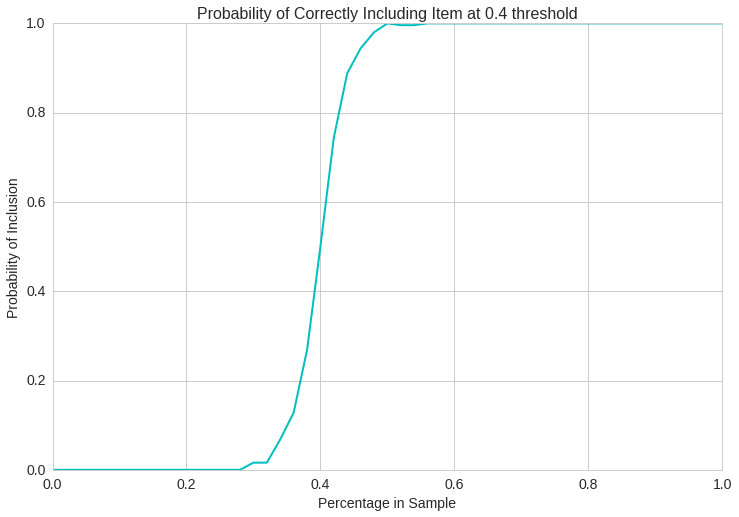

In [12]:
n, d, m = 250, 50, 1000
data = numpy.zeros((n, d+1))

for i in xrange(d+1):
    t = float(i)/(d+1)
    
    for j in xrange(n):
        ff = FrequentFinder(8)
        p = numpy.random.random(m)
        
        for k in xrange(m):
            if p[k] <= t:
                ff.summarize(7)
            else:
                ff.summarize(numpy.random.randint(100))
        
        data[j, i] = 7 in ff.from_summaries(0.4, 0.01)

plt.figure(figsize=(12, 8))
plt.title("Probability of Correctly Including Item at 0.4 threshold", fontsize=16)
plt.xlabel("Percentage in Sample", fontsize=14)
plt.ylabel("Probability of Inclusion", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(numpy.arange(d+1)/50., data.mean(axis=0), c='c', linewidth=2)

It looks like we both get the expected distribution from this, where having the same proportion in the sample as the threshold only yields a ~50% chance of being included in the list. Next, we can see the effect that increasing the amount of memory used by the data structure has. We would expect that as we added more memory, this curve should tighten and go from 0 to 1 faster.

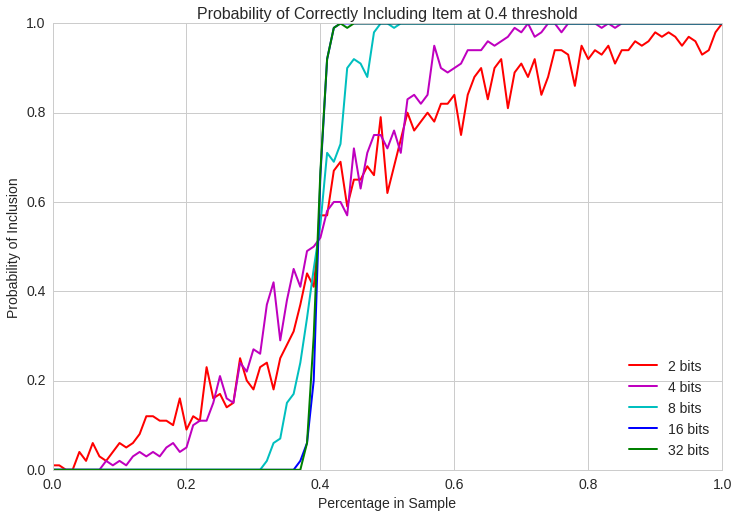

In [13]:
plt.figure(figsize=(12, 8))
plt.title("Probability of Correctly Including Item at 0.4 threshold", fontsize=16)
plt.xlabel("Percentage in Sample", fontsize=14)
plt.ylabel("Probability of Inclusion", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

n, d, m = 100, 100, 2500
idx = numpy.arange(d+1)/100.
for c, b in enumerate([2, 4, 8, 16, 32]):
    data = numpy.zeros((n, d+1))

    for i in xrange(d+1):
        t = float(i)/(d+1)

        for j in xrange(n):
            ff = FrequentFinder(b)
            p = numpy.random.random(m)

            for k in xrange(m):
                if p[k] <= t:
                    ff.summarize(7)
                else:
                    ff.summarize(numpy.random.randint(100))

            data[j, i] = 7 in ff.from_summaries(0.4, 0.01)
    
    plt.plot(idx, data.mean(axis=0), c='rmcbg'[c], linewidth=2, label="{} bits".format(b))

plt.legend(fontsize=14, loc=4)

It looks like our hypothesis is correct, that the more memory which is used, the faster the transition from 0 to 1 at the threshold. It doesn't seem to get significantly better from 16 bits to 32 bits, but this example is also a bit coarse grain for computational time. However, the message is clearly that the more memory used, the fewer false positives and false negatives there will be. 

I have shown empirical evidence that this algorithm works well, along with some theoretical intuition behind how the algorithm works. However, the paper proves four main points: (1) the algorithm only requires $\log \log n$ memory, (2) the algorithm uniformly samples every point in the stream, (3) the probability of returning all frequent element is bounded by $1 - \delta$, (4) the probability of returning a rare element is bounded by $\frac{\delta}{3}$.

### The algorithm requires only log log n memory

<b>Theorem 3.1:</b> <i> Arbitrarily given $\theta \in (0, 1)$, $\gamma \in (0, 1)$ and $\delta \in (0, 1)$, set $b \geq \lceil lg((\theta\gamma/2)^{-2} ln(3((1-\gamma/2)\theta\delta)^{-1}))\rceil + 3$ in order for the output from the algorithm to contain all frequent items $\{s \in \Sigma \quad | \quad f(s) \geq \theta N\}$ and does not contain any rare items of $\{s \in \Sigma \quad | \quad f(s) < (1 - \gamma)\theta N\}$ with probability at least $1 - \sigma$ for any input stream $x = (x_{1}, \dots, x_{N})$.</i>

Basically, this theorem is putting a complicated limit on the number of bits needed to achieve a specific probability for identifying correct elements. Previously, the use of the $\theta$ and $\gamma$ parameters was made fairly clear in setting the thresholds needed for the return values. This theorem tells us finally how to involve the $\delta$ parameter in setting the number of bits needed.

The authors of the paper then use this equation in order to show that only $\log \log n$ memory is needed to correctly identify frequent elements with an error rate of $1 - \theta$. 

\begin{align}
    2^{b}(b + \sigma) + log log N &\approx \frac{32 \log \left( \frac{3}{(1 - \gamma/2)\theta\delta} \right)}{(\gamma\theta)^{2}} \log \left( \frac{\log \left( \frac{3}{1 - \gamma/2)\theta\delta} \right)}{(\gamma\theta)^{2}} \right) + \log \log N \\
    &= O \left( \frac{\log^{2}(\frac{1}{\theta})}{\theta^{2}} + \log \log N \right) \\
\end{align}

At first this may seem to be a big leap, but it's import to know that using big-O notation gets rid of a large portion of the equation since most of the elements are constants.

So, by setting the number of bits to be on the scale of $\log \log N$ where $N$ is the total stream size, you can get very good performance. This does not solve cases where $N$ is not known beforehand, but it is less of a problem to overallocate memory in this setup using $\log \log N$ instead of $\log N$ memory.

### The algorithm uniformly samples every point in the stream

One key aspect of the algorithm is that it must have an equal probability of sampling every item. At first, that doesn't seem to be the case, because it has a sampling rate of $2^{-h}$ where h increments every $2^{b}$ sampled elements (not necessarily seen elements). Initially, this seems like it favors earlier elements, because h is smaller, making $2^{-h}$ larger and thus more likely for an element to be sampled. However, consider a process by which you throw away element with probability $\frac{1}{2}$. The number of remaining elements is easily modelled by the binomial distribution, which is used here every "flush" step. Now, every "flush" step corresponds to both incrementing $h$, which makes it $\frac{1}{2}$ as likely to sample future elements, and to randomly drawing a binomial sample, which is similar to halving the counts of the previously stored elements. This works out to the probability of $x_{i}$ remaining a sample at the end of the algorithm of $2^{-h}$, which is uniform sampling.

### The probability of returning all frequent elements is at least 1 - $\delta$

Previously I had mentioned the amount of memory which should be used to attain the the desired accuracy of $1 - \delta$. The paper shows this as follows:

<b>Lemma 3.3.</b> <i> Set $b \geq \lceil \log ((\theta\gamma/2)^{-2} \log(3((1 - \gamma/2)\theta\delta)^{-1}))\rceil + 3$. If $h \geq 1$ then </i>

\begin{equation}
Pr \left[ \sum\limits_{s' \in K} K[s'] \geq 2^{b-2} \right] \geq 1 - \frac{\delta}{3}
\end{equation}

The proof is as follows: As we add elements to the structure, we increase the counts, making the counts monotonically nondecreasing (because the count either increases if the item is seen, or stay the same if it is not seen). However, these counts will all decrease when the structure is flushed when the sum of the counts is equal to $2^{b}$. The probability that the new counts then follow the binomial distribution, since we sample from a binomial distribution to get the new counts, and so

\begin{equation}
    Pr \left[ \sum\limits_{s' \in K} K[s'] < 2^{b-2} \right] \leq \sum\limits_{j=0}^{2^{b-2}} {{n}\choose{j}}\frac{1}{2^{2^{b}}}
\end{equation}

Using an inequality to bound the binomial distribution

\begin{equation}
    \sum\limits_{j=0}^{(p-t)n} {{n}\choose{j}}p^{j}(1-p)^{n - j} \leq e^{-2t^{2}n} \\
\end{equation}

the authors then plug in $n = 2^{b}$, $p = 1/2$, and $t = 1/4$ to get the following:

\begin{align}
    \sum\limits_{j=0}^{2^{b-2}} {{n}\choose{j}}\frac{1}{2^{2^{b}}} &\leq e^{-2(1/4)^{2}2^{b}} \\
    &= e^{-2^{b-3}} \\
    &\leq e^{\log(\delta/3)} \\
    &= \frac{\delta}{3} \\
\end{align}

### The probability of returning a rare element is $\frac{\delta}{3}$

Lastly, we need to show that we return frequent elements with probability $1 - \delta$. The authors do this in several parts, shown below directly from the paper:

<b>Lemma 3.6.</b> <i>Set $b \geq \lceil \log((\theta\gamma/2)^{-2} \log(3((1 - \gamma/2)\theta\gamma)^{-1}))\rceil + 3$. On the condition that $\sum_{s' \in K} K[s'] \geq 2^{b-2}$ holds at the end of the algorithm, the probability that the output of the algorithm contains a rare element s satisfying that f(s) < $(1 - \gamma)\theta N$ is at most $\frac{\delta}{3}$</i>

<i>Proof</i>. Suppose $s \in \Sigma$ is a rare element satisfying $f(s) < (1 - \gamma)\theta N$. Let $N = |x|$, $M = N - f(s)$, $n = \sum_{s' \in K} K[s'] \geq 2^{b-2}$ and $k = (1 - (1 - \gamma/2)\theta)n)$. Then $k/n = 1 - (1 - \gamma/2)\theta$ and $M/N \geq 1 - (1 - \gamma)\theta$, thus:

\begin{align}
    Pr[K[s] \geq (1 - \gamma/2) \theta n] &= Pr[n - K[s] < (1 - (1 - \gamma/2) \theta )n] \\
                                          &= \sum\limits_{j=0}^{(1-(1-\gamma/2) \theta )n} {\frac{ {{M}\choose{j}} {{N-M}\choose{n-j}}}{{{N}\choose{n}}}} \\
                                          &\leq e^{-2((1-(1-\gamma/2)\theta)-(1-(1-\gamma)\theta))^{2}2^{b-2}} \\
                                          &= e^{-2(\theta\gamma/2)^{2}2^{b-2}} \\
                                          &\leq \frac{(1-\gamma/2)\theta\delta}{3}\\ 
\end{align}

We know that the algorithm outputs at most $1/(\theta(1 - \gamma/2))$ elements, making the false positive probability equal to

\begin{equation}
    \frac{1}{\theta(1 - \gamma/2)} \cdot \frac{(1 - \gamma)\theta\delta}{3} \leq \frac{\delta}{3}
\end{equation}

This is because both $\delta$ and $\theta$ are values which are at most 1, and so $\delta$ by itself is an upper bound on that quantity. 

## Conclusions

At this point, we've implemented the algorithm, evaluated its performance, seen how changing the parameters of the algorithm can effect performance, and seen theoretical proofs of its performance. On a personal note, I was extremely surprised to see an algorithm which could identify frequent elements which required such a small amount of memory. Using very little memory at all the algorithm was able to identify these frequent elements in a stream, without any knowledge of how many frequent elements there are, or how long the stream is. This seems like it will important applications for many streaming settings, and a very useful algorithm overall.